## Tutorial 1: Classic Mean Risk Optimization

## 1. Downloading the data:

In [126]:
%%capture
# MatPlotLib settings
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# Swan Colors
swan_colors = ['#31597F', '#7B96B0', '#C3D9E9', '#DAE1E8']
mpl.rcParams['lines.color'] = '#31597F'
mpl.rcParams['text.color'] = '#31597F'
mpl.rcParams['axes.prop_cycle'] = cycler(color=swan_colors)
mpl.rcParams['lines.linewidth'] = 2
plt.rcParams["figure.figsize"] = (10,5)
import matplotlib.ticker as ticker

# Define the formatter
formatter = ticker.StrMethodFormatter('{x:,.0f}')

from PIL import Image
fig, ax = plt.subplots()
img = Image.open('swan.jpg')
width, height = ax.figure.get_size_inches()*fig.dpi
wm_width = int(width / 2) 
scaling = (wm_width / float(img.size[0]))
wm_height = int(float(img.size[1])*float(scaling))
img = img.resize((wm_width, wm_height), Image.ANTIALIAS)

def add_watermark(ax, img):
    ax.imshow(img, aspect='equal', zorder=1, alpha=0.2, extent=(0.3, 1.6, 0.05, 0.3), transform=ax.transAxes)
    



In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2023-03-26'

# Tickers of assets
assets = ['BTC-USD', 'SPY', 'QQQ', 'TLT', 'HYG', 'KBE', 'GLD', 
          'SLV', 'GSG', 'VO', 'VEA', 'VEU', 'IEV', 
          'ACWI', 'VNQ', 'VTI']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  16 of 16 completed


In [3]:
# Show summary information on each ticker 
tmp_lst = []
fields = ['symbol', 'shortName', 'fullExchangeName', 'currency']
for ticker in assets:
    tmp_dict = {}
    tmp_data = yf.Ticker(ticker)
    for field in fields:
        tmp_dict[field] = tmp_data.info.get(field)
    tmp_lst.append(tmp_dict)
info_df = pd.DataFrame(tmp_lst)
info_df

,symbol,shortName,fullExchangeName,currency
0,ACWI,iShares MSCI ACWI ETF,NasdaqGM,USD
1,BTC-USD,Bitcoin USD,CCC,USD
2,GLD,SPDR Gold Trust,NYSEArca,USD
3,GSG,iShares GSCI Commodity-Indexed,NYSEArca,USD
4,HYG,iShares iBoxx $ High Yield Corp,NYSEArca,USD
5,IEV,iShares Europe ETF,NYSEArca,USD
6,KBE,SPDR S&P Bank ETF,NYSEArca,USD
7,QQQ,"Invesco QQQ Trust, Series 1",NasdaqGM,USD
8,SLV,iShares Silver Trust,NYSEArca,USD
9,SPY,SPDR S&P 500,NYSEArca,USD


In [4]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,ACWI,BTC-USD,GLD,GSG,HYG,IEV,KBE,QQQ,SLV,SPY,TLT,VEA,VEU,VNQ,VO,VTI
Date,,,,,,,,,,,,,,,,
2016-01-05,0.0912%,-0.2611%,0.2819%,-0.9915%,0.1873%,-0.6327%,-0.1815%,-0.1735%,0.9098%,0.1691%,-0.4035%,-0.1106%,-0.2344%,1.9297%,0.1012%,0.2239%
2016-01-06,-1.5124%,-0.6609%,1.4441%,-2.9328%,0.0000%,-1.6811%,-1.4550%,-0.9606%,0.3757%,-1.2614%,1.3476%,-1.8268%,-1.7148%,-0.2740%,-1.8456%,-1.3402%
2016-01-07,-2.3312%,6.7450%,1.4140%,-0.9580%,-0.6480%,-1.8135%,-3.0760%,-3.1313%,1.9461%,-2.3992%,0.1795%,-1.8889%,-2.1511%,-1.9483%,-2.2495%,-2.4510%
2016-01-08,-1.1555%,-1.0519%,-0.4428%,-0.1488%,-0.2634%,-1.0026%,-2.0311%,-0.8201%,-2.3495%,-1.0976%,0.4478%,-1.2356%,-1.1969%,-1.3374%,-1.2912%,-1.1403%
2016-01-09,0.0000%,-1.2398%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


## 2. Estimating Mean Variance Portfolios

### 2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [5]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,ACWI,BTC-USD,GLD,GSG,HYG,IEV,KBE,QQQ,SLV,SPY,TLT,VEA,VEU,VNQ,VO,VTI
weights,0.0000%,18.1507%,47.3936%,0.0003%,0.0000%,0.0000%,0.0000%,30.9439%,0.0000%,0.0000%,3.5114%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


### 2.2 Plotting portfolio composition

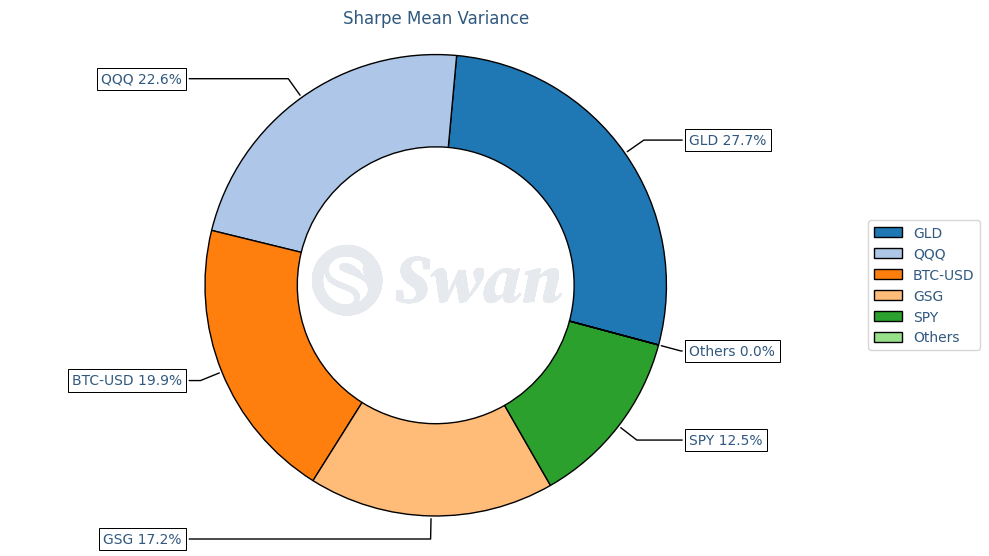

In [159]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

img = mpimg.imread('swan.png')
imagebox = OffsetImage(img, zoom=0.15) 
imagebox.image.set_alpha(0.10)  # Change the alpha settings to 0.10


ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.07, nrow=25, 
                 height=6, width=10, ax=None)

# Add the watermark image to the chart
ab = AnnotationBbox(imagebox, (0.5, 0.5),
                    xycoords='axes fraction',
                    frameon=False)
ax.add_artist(ab)

# Set the aspect ratio of the axes
ax.set_aspect('equal', adjustable='box')

plt.show()


### 2.3 Calculate efficient frontier

In [7]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,ACWI,BTC-USD,GLD,GSG,HYG,IEV,KBE,QQQ,SLV,SPY,TLT,VEA,VEU,VNQ,VO,VTI
0,0.0000%,0.0000%,13.1397%,3.3812%,60.2443%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,23.2348%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
1,0.0000%,4.9653%,23.4976%,3.3700%,47.7830%,0.0000%,0.0000%,3.3391%,0.0000%,0.0000%,17.0450%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2,0.0000%,7.0895%,28.1306%,3.3734%,35.7843%,0.0000%,0.0000%,8.8758%,0.0000%,0.6765%,16.0699%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
3,0.0000%,8.9218%,32.1454%,3.3496%,25.0987%,0.0000%,0.0000%,13.2998%,0.0000%,1.8768%,15.3078%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
4,0.0000%,10.6148%,35.8534%,3.3280%,15.2265%,0.0000%,0.0000%,17.3875%,0.0000%,2.9855%,14.6043%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


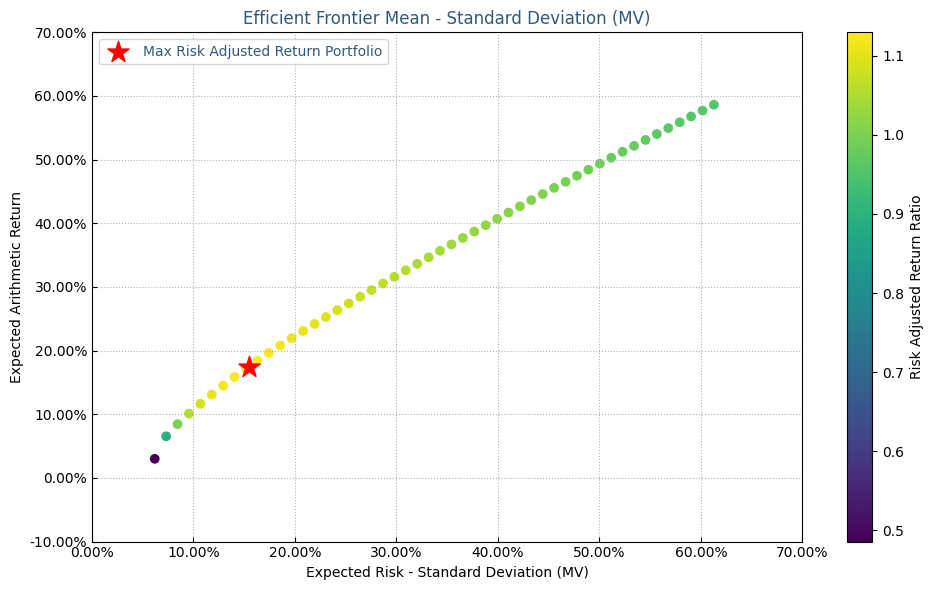

In [ ]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

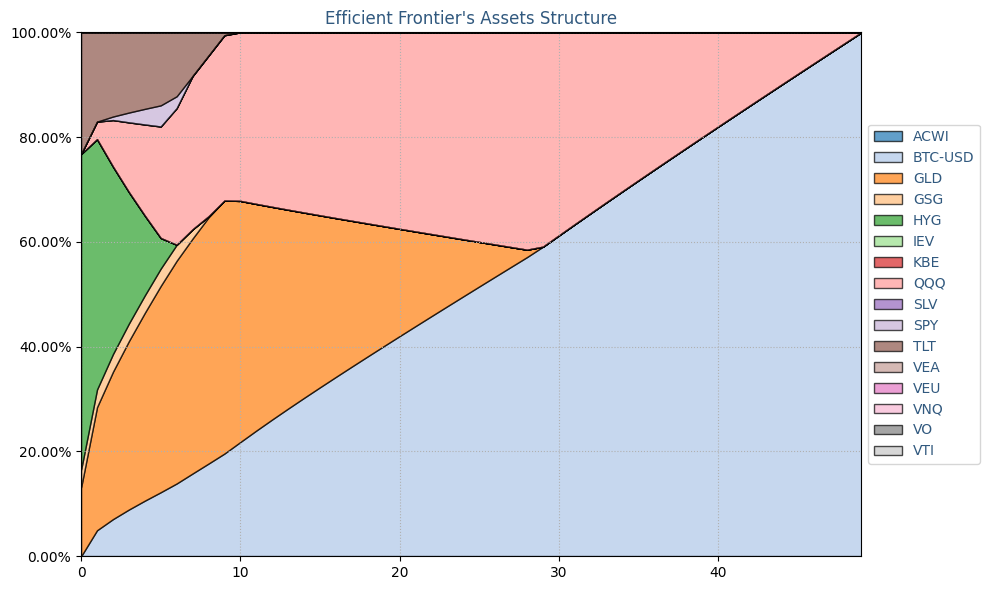

In [9]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Mean Risk Portfolios

In this part I will calculate optimal portfolios for several risk measures. First I'm going to calculate the portfolio that maximizes risk adjusted return when CVaR is the risk measure, then I'm going to calculate the portfolios that maximize the risk adjusted return for all available risk measures.

### 3.1 Calculating the portfolio that maximizes Return/CVaR ratio.

In [10]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,ACWI,BTC-USD,GLD,GSG,HYG,IEV,KBE,QQQ,SLV,SPY,TLT,VEA,VEU,VNQ,VO,VTI
weights,0.0000%,17.2107%,55.8505%,0.0000%,0.0000%,0.0000%,0.0000%,20.2148%,0.0000%,0.0000%,6.7240%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


### 3.2 Plotting portfolio composition

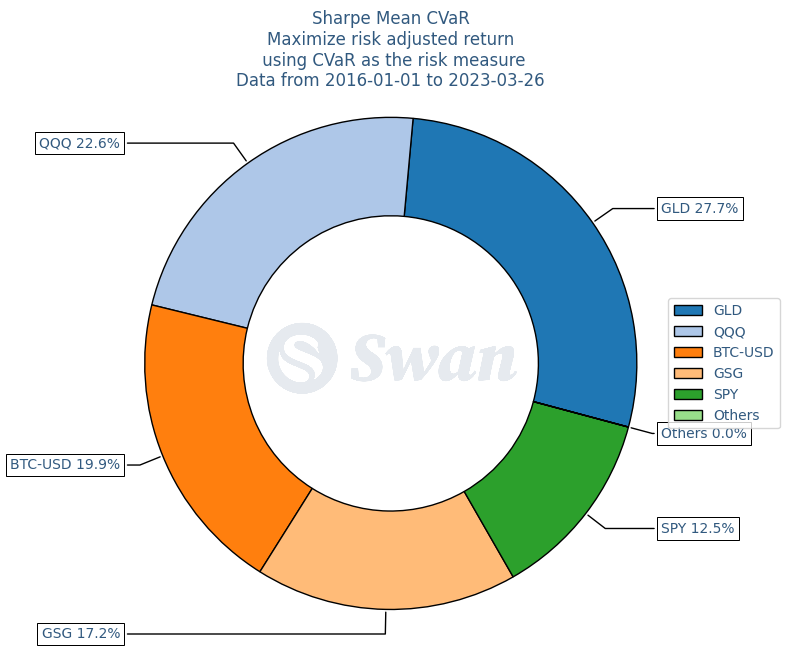

In [160]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

img = mpimg.imread('swan.png')
imagebox = OffsetImage(img, zoom=0.15) 
imagebox.image.set_alpha(0.10)  # Change the alpha settings to 0.10

ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR\n' + 
                 f'Maximize risk adjusted return\n using CVaR as the risk measure\nData from {start} to {end}', 
                 others=0.01, nrow=25, cmap = "tab20",
                 height=8, width=8, ax=None)


# Add the watermark image to the chart
ab = AnnotationBbox(imagebox, (0.5, 0.5),
                    xycoords='axes fraction',
                    frameon=False)
ax.add_artist(ab)

# Set the aspect ratio of the axes
ax.set_aspect('equal', adjustable='box')

plt.show()


### 3.3 Calculate efficient frontier

In [12]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,ACWI,BTC-USD,GLD,GSG,HYG,IEV,KBE,QQQ,SLV,SPY,TLT,VEA,VEU,VNQ,VO,VTI
0,0.0000%,0.0000%,17.4672%,3.0345%,60.1461%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,19.3522%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
1,0.0000%,6.5974%,28.8641%,0.0000%,51.8284%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,12.7101%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2,0.0000%,9.0877%,34.7188%,0.0000%,39.5864%,0.0000%,0.0000%,3.6892%,0.0000%,0.0000%,12.9178%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
3,0.0000%,10.4393%,41.2163%,0.0000%,22.5654%,0.0000%,0.0000%,11.4295%,0.0000%,0.0000%,14.3495%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
4,0.0000%,12.2093%,47.4352%,0.0000%,9.9963%,0.0000%,0.0000%,15.4849%,0.0000%,0.0000%,14.8743%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%


RuntimeError: Can not put single artist in more than one figure

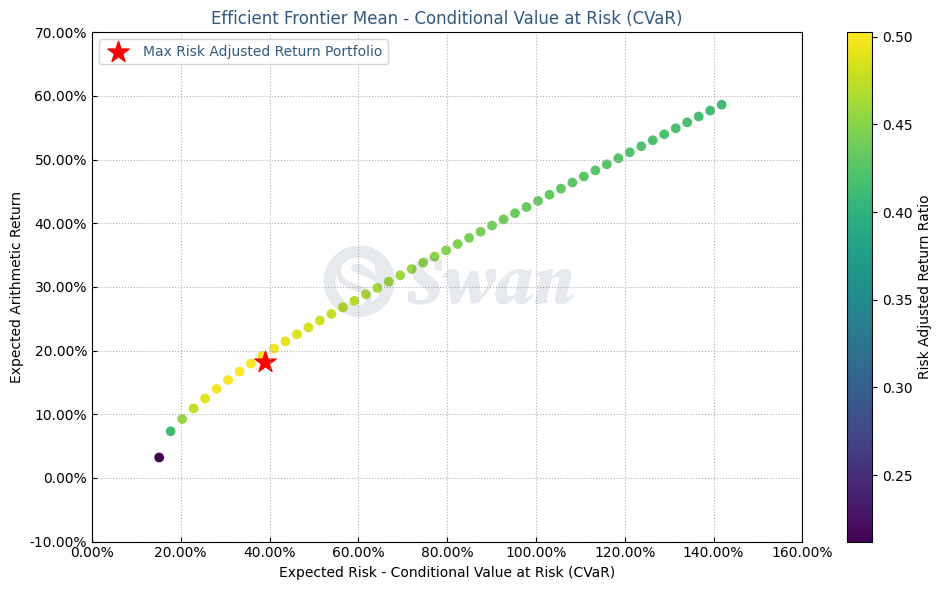

In [166]:


label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

# Add the watermark image to the chart
ab = AnnotationBbox(imagebox, (0.5, 0.5),
                    xycoords='axes fraction',
                    frameon=False)
ax.add_artist(ab)

# Set the aspect ratio of the axes
ax.set_aspect('equal', adjustable='box')

plt.show()


RuntimeError: Can not put single artist in more than one figure

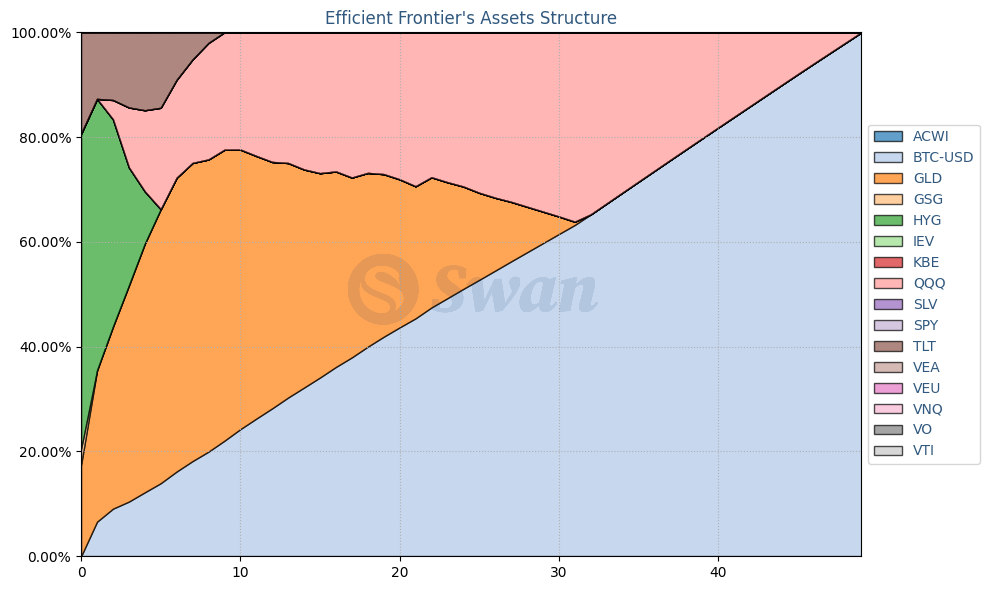

In [167]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)
# Add the watermark image to the chart
ab = AnnotationBbox(imagebox, (0.5, 0.5),
                    xycoords='axes fraction',
                    frameon=False)
ax.add_artist(ab)

# Set the aspect ratio of the axes
ax.set_aspect('equal', adjustable='box')

plt.show()


### 3.4 Calculate Optimal Portfolios for Several Risk Measures

 ## Risk Measures analyzed:

 'MV': Standard Deviation.

 'MAD': Mean Absolute Deviation.
 
 'MSV': Semi Standard Deviation.

 'FLPM': First Lower Partial Moment (Omega Ratio).
 
 'SLPM': Second Lower Partial Moment (Sortino Ratio).
 
 'CVaR': Conditional Value at Risk.
 
 'EVaR': Entropic Value at Risk.
 
 'WR': Worst Realization (Minimax)
 
 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
 
 'ADD': Average Drawdown of uncompounded cumulative returns.
 
 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
 
 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
 
 'UCI': Ulcer Index of uncompounded cumulative returns.


In [15]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [169]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')


,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
ACWI,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BTC-USD,18.15%,15.10%,18.78%,14.17%,18.82%,17.21%,20.33%,15.06%,19.47%,7.01%,16.78%,9.74%,19.90%
GLD,47.39%,43.80%,50.03%,44.10%,50.30%,55.85%,11.23%,0.00%,35.58%,32.96%,32.69%,43.48%,27.72%
GSG,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,12.65%,9.87%,11.32%,9.22%,17.21%
HYG,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
IEV,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
KBE,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
QQQ,30.94%,26.85%,26.59%,27.61%,26.10%,20.21%,0.00%,0.00%,9.86%,50.16%,9.16%,37.56%,22.62%
SLV,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
SPY,0.00%,13.79%,0.00%,13.92%,0.00%,0.00%,0.00%,0.00%,22.44%,0.00%,30.05%,0.00%,12.55%


<Axes: >

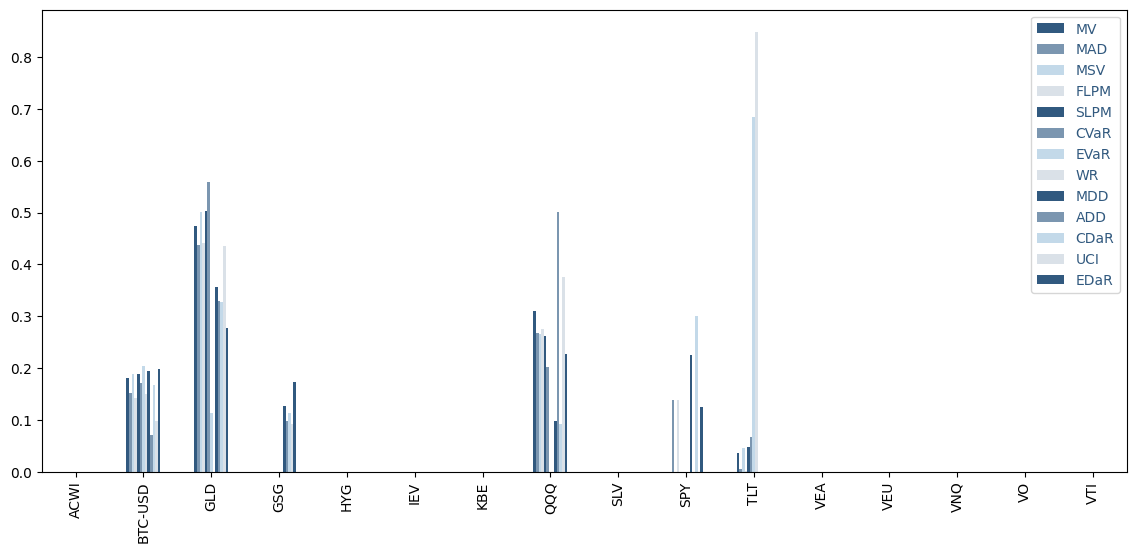

In [17]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

## 4. Constraints on Assets and Assets Classes

### 4.1 Creating the constraints

In this part I use dictionaries to create the constraints but is prefered to create the tables in excel and upload them with pandas.read_excel.

In [18]:
asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','APA','MMC','JPM',
                            'ZION','PSA','BAX','BMY','LUV','PCAR','TXT','TMO',
                            'DE','MSFT','HPQ','SEE','VZ','CNP','NI','T','BA'], 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Consumer Staples',
                              'Consumer Staples','Energy','Financials',
                              'Financials','Financials','Financials',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Industrials','Health Care','Industrials',
                              'Information Technology','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities','Telecommunications Services','Financials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes', 'Classes',
                        'Classes'],
               'Set': ['', 'Industry', 'Industry', 'Industry', 'Industry'],
               'Position': ['', 'Financials', 'Utilities', 'Industrials',
                            'Consumer Discretionary'],
               'Sign': ['<=', '<=', '<=', '<=', '<='],
               'Weight': [0.10, 0.2, 0.2, 0.2, 0.2],
               'Type Relative': ['', '', '', '', ''],
               'Relative Set': ['', '', '', '', ''],
               'Relative': ['', '', '', '', ''],
               'Factor': ['', '', '', '', '']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,10.0000%,,,,
1,False,Classes,Industry,Financials,<=,20.0000%,,,,
2,False,Classes,Industry,Utilities,<=,20.0000%,,,,
3,False,Classes,Industry,Industrials,<=,20.0000%,,,,
4,False,Classes,Industry,Consumer Discretionary,<=,20.0000%,,,,


In [19]:
A, B = rp.assets_constraints(constraints, asset_classes)

### 4.2 Optimize the portfolio with the constraints

In [20]:
port.ainequality = A
port.binequality = B

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

NameError: The matrix ainequality must have the same number of columns that assets' number

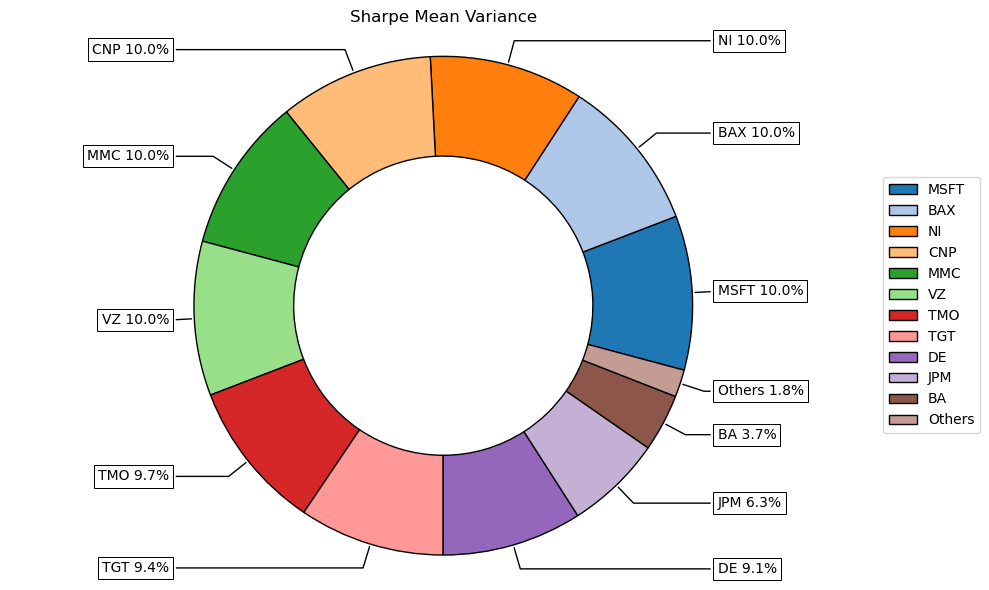

In [ ]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [ ]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)

,Industry,weights
APA,Energy,0.0000%
BA,Financials,3.7276%
BAX,Health Care,10.0000%
BMY,Health Care,0.0000%
CMCSA,Consumer Discretionary,1.7582%
CNP,Utilities,10.0000%
CPB,Consumer Staples,0.0000%
DE,Industrials,9.0759%
HPQ,Information Technology,0.0000%
JCI,Consumer Discretionary,0.0000%


In [ ]:
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)

,weights
Industry,
Consumer Discretionary,11.1977%
Consumer Staples,0.0000%
Energy,0.0000%
Financials,20.0000%
Health Care,19.7215%
Industrials,9.0759%
Information Technology,10.0000%
Materials,0.0000%
Telecommunications Services,10.0050%


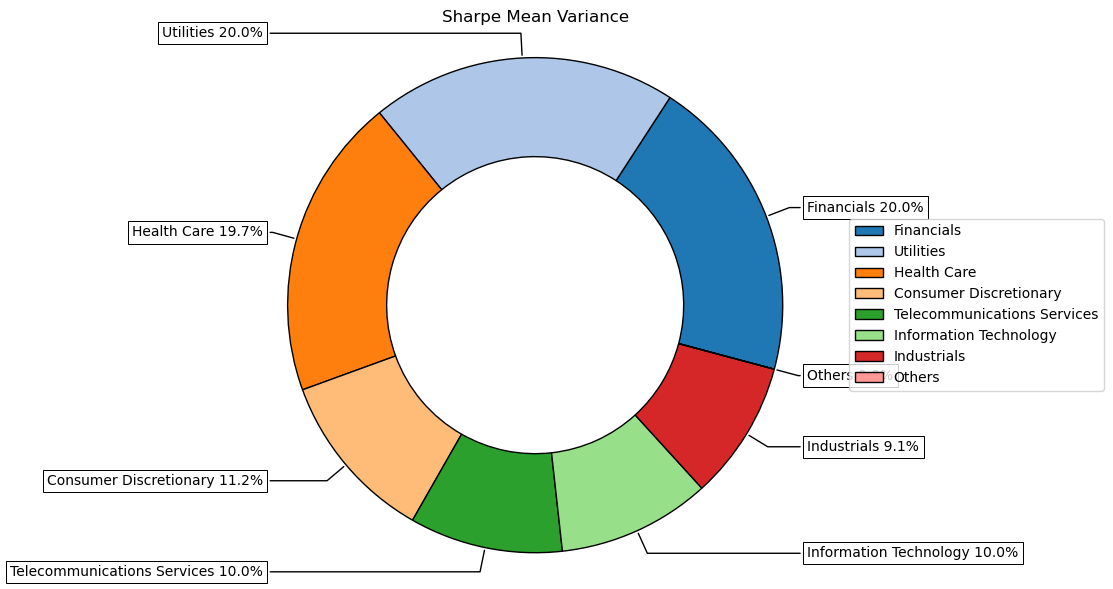

In [ ]:
ax = rp.plot_pie(w=w_classes, title='Sharpe Mean Variance', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)